# How to Find and Plot Level 2 Data from Multiple Granules on a Map using Python

## Overview

Level 2 data from Low Earth Orbit (LEO) satellites are often organized into \"granules\" that contain spatial sets of data that may not match up with the region of interest.  If the region is smaller than the granule the user can create a spatial subset.  If the region spans mulitple granules, each granule may be ploted individually, or the data can be aggregated and plotted at once.

This how-to assumes that the user has searched for the data from the ["JPSS-1 CrIS Level 2 CLIMCAPS: Atmosphere cloud and surface geophysical state V2"](https://doi.org/10.5067/LESQUBLWS18H) data over the Gulf of Mexico on 2021-09-23 within a bounding box defined by the following pairs of longitude and latitude: (-100, 15) and (-75, 30).  This data search may be achieved either by using the GES DISC web interface or by performing a granule search as demostrated below using the [Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html).

The data plotted in this example is the Surface Air Temperature from the CLIMCAPS product, but can be modified to apply to other other Level 2 products.

*Dataset Citation:*

Chris Barnet (2019), Sounder SIPS: JPSS-1 CrIS Level 2 CLIMCAPS: Atmosphere cloud and surface geophysical state V2, Greenbelt, MD, USA, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: [Data Access Date], 10.5067/LESQUBLWS18H

## Prerequisites

This example code is written in Python 3.9 and requires these libraries and files: 
- numpy
- requests
- netCDF 
- matplotlib
- cartopy  
- netrc file with valid Earthdata Login credentials ([How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?keywords=prerequisite&title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files))
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)
- wget (https://www.gnu.org/software/wget/)

*Note: If the files to be aggregated are not in netCDF format, a different library (e.g. Xarray) will have to be used.*

### 1. Import Libraries

In [1]:
import glob
import numpy as np
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import requests

### 2. Extract URLs from the CMR and Download Granules

To search for URLs of the granules of interest, we perform a CMR query using the ShortName (SNDRJ1IML2CCPRET) and Version ID of the dataset as well as the time range and bounding box of the time and region of interest. These URLs will be stored in a list for downloading.

In [2]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

# CMR API query
cmr_response = requests.get(cmr_url, 
                            params={
                                'short_name': 'SNDRJ1IML2CCPRET',
                                'version': '2',
                                'temporal': '2021-09-23T00:00:00Z,2021-09-24T00:00:00Z',
                                'bounding_box': "-100,15,-75,30",
                                'page_size': 200,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                            )

# create a list of the data URLs
listofurls = []
for i in range(len(cmr_response.json()['feed']['entry'])):
    link = cmr_response.json()['feed']['entry'][i]['links'][0]['href']
    print(link)
    listofurls.append(link)

https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0606.m06.g062.L2_CLIMCAPS_RET.std.v02_53.G.211223053311.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0612.m06.g063.L2_CLIMCAPS_RET.std.v02_53.G.211223053331.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0748.m06.g079.L2_CLIMCAPS_RET.std.v02_53.G.211223053551.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0754.m06.g080.L2_CLIMCAPS_RET.std.v02_53.G.211223053611.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1724.m06.g175.L2_CLIMCAPS_RET.std.v02_53.G.211223055024.nc
https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.202109

The following block of code uses wget to download the Level 2 files in the region of interest to the current directory.

In [3]:
""" listofurls = ['https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0606.m06.g062.L2_CLIMCAPS_RET.std.v02_53.G.211223053311.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0612.m06.g063.L2_CLIMCAPS_RET.std.v02_53.G.211223053331.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0748.m06.g079.L2_CLIMCAPS_RET.std.v02_53.G.211223053551.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T0754.m06.g080.L2_CLIMCAPS_RET.std.v02_53.G.211223053611.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1724.m06.g175.L2_CLIMCAPS_RET.std.v02_53.G.211223055024.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1900.m06.g191.L2_CLIMCAPS_RET.std.v02_53.G.211223055205.nc',
              'https://data.gesdisc.earthdata.nasa.gov/data/JPSS1_Sounder_Level2/SNDRJ1IML2CCPRET.2/2021/266/SNDR.J1.CRIMSS.20210923T1906.m06.g192.L2_CLIMCAPS_RET.std.v02_53.G.211223055225.nc'] """

fname='dataurls.txt'
f = open(fname,'w')
for url in listofurls:
    f.write(url+'\n')
f.close()

os.system('wget -i dataurls.txt')


0

### 3. Aggregate and Plot

The following block of code reads the names of the local netCDF files and plots the surface Air Temperature from the first file in the list.

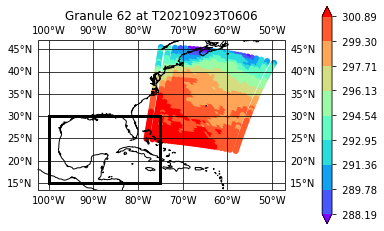

In [5]:
# glob will read in the relevant datafiles to plot.
datafiles = sorted(glob.glob('*.nc'))

# these are the relevant science variables
varname = 'surf_air_temp'
qcvarname =  'surf_air_temp_qc'

# this reads the data from the first file in the 
fid = netCDF4.Dataset(datafiles[0] ,mode='r',format='NETCDF4')
lat = fid.variables['lat'][:]
lon = fid.variables['lon'][:]
sol_zen = fid.variables['sol_zen'][:] # this variable will be used to separate the day from the night 
data = fid.variables[varname][:]
dataqc = fid.variables[qcvarname][:]

# this sets up the plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='black')
lowerlimit = data.min()
upperlimit = data.max()
ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(lon,lat,c=data, cmap=cmap, norm=norm, edgecolor='black', linewidth=0)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")


bb = ((-100, 15),(-75, 30)) # this is the bounding box indicating the lower left and upper right pairs of Longitude and Latitude

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=3,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=3,transform=ccrs.PlateCarree())

plt.title('Granule 62 at T20210923T0606')

plt.show()
fid.close()

The next step is to loop over all the data files to aggregate the data to be plotted.

In [6]:
# initialize the array into which the data will be aggregated.
lon_agg = np.array([])
lat_agg = np.array([])
sol_zen_agg = np.array([])
data_agg = np.array([])
dataqc_agg = np.array([])

for i,file in enumerate(datafiles):
    # open the file
    fid = netCDF4.Dataset( file ,mode='r',format='NETCDF4')

    # read the longitude, latitude, and other relevant variables
    lat = fid.variables['lat'][:]
    lon = fid.variables['lon'][:]
    sol_zen = fid.variables['sol_zen'][:]
    data = fid.variables[varname][:]
    dataqc = fid.variables[qcvarname][:]
    
    lon_agg = np.append(lon_agg,lon.flatten().copy())
    lat_agg = np.append(lat_agg,lat.flatten().copy())
    sol_zen_agg = np.append(sol_zen_agg,sol_zen.flatten().copy())
    data_agg = np.append(data_agg,data.flatten().copy()) 
    dataqc_agg = np.append(dataqc_agg,dataqc.flatten().copy()) 

The following block of code plots all of the aggregated data.

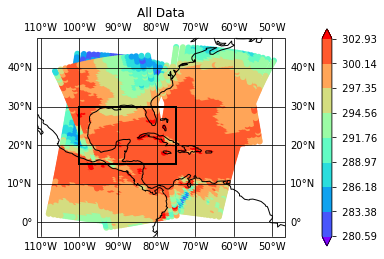

In [7]:
# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg,lat_agg,c=data_agg, cmap=cmap, norm=norm, edgecolor='black', linewidth=0)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('All Data')

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()


Since some satellite observations from different orbits may be on top of each other, only the most recent symbol plotted may be visible in the figure.  Therefore, plotting smaller symbols may make it easier to distinguish individual footprints.

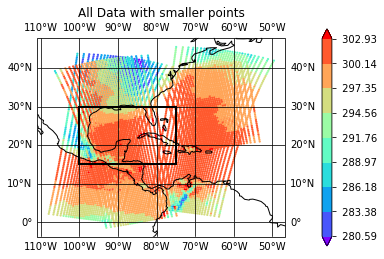

In [8]:
# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg,lat_agg,c=data_agg, cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5) # s=5 will make the symbols smaller

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('All Data with smaller points')

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()


The above figure shows that, even with smaller symbols, it is difficult to distinguish individual daytime and nighttime observations when the orbits are overlaid. The following example shows that we can use the solar zenith angle variable to only select the daytime observation (i.e., when sol_zen_agg < 90).

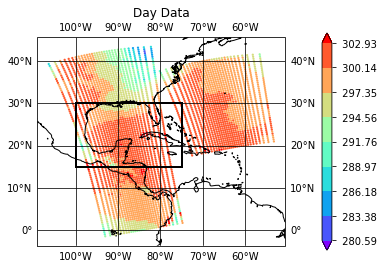

In [9]:
daymask = sol_zen_agg < 90.

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[daymask],lat_agg[daymask],c=data_agg[daymask], norm=norm, cmap=cmap, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Day Data')

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

Now, just plot the nighttime footprints:

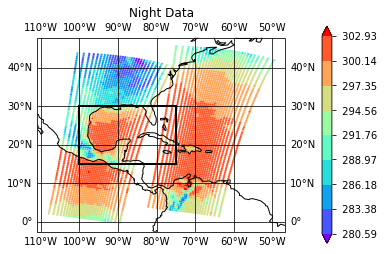

In [10]:
nightmask = sol_zen_agg >= 90

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[nightmask],lat_agg[nightmask],c=data_agg[nightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Night Data')

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

The next block of code uses the solar zenith angle and the quality flag to create a mask that will just plot the "good" data at night.  

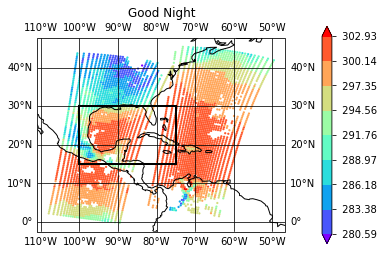

In [11]:
gooddatamask = np.logical_or(dataqc_agg == 0, dataqc_agg == 1)

nightmask = sol_zen_agg >= 90

goodnightmask = np.logical_and(gooddatamask,nightmask)


# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[goodnightmask],lat_agg[goodnightmask],c=data_agg[goodnightmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=5)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Good Night')

# the following lines plots a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()

By selecting only the coordinates within the bounding box, we can plot slightly larger symbols and still see individual footprints.

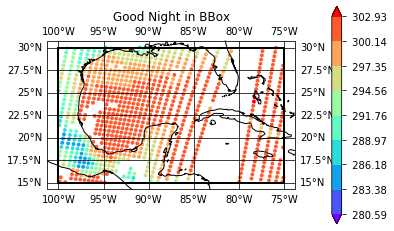

In [12]:
gooddatamask = np.logical_or(dataqc_agg == 0, dataqc_agg == 1)
nightmask = sol_zen_agg >= 90

goodnightmask = np.logical_and(gooddatamask,nightmask)

inbbox = np.logical_and(np.logical_and(lon_agg > bb[0][0],lon_agg < bb[1][0]),
                        np.logical_and(lat_agg > bb[0][1],lat_agg < bb[1][1]))

goodnightinbboxmask = np.logical_and(goodnightmask,inbbox)

# this sets up the plot 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.75, color='black')
lowerlimit = data_agg.min()
upperlimit = data_agg.max()

cmap=plt.cm.rainbow

bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
numint = ncolors
c=plt.scatter(lon_agg[goodnightinbboxmask],lat_agg[goodnightinbboxmask],c=data_agg[goodnightinbboxmask], cmap=cmap, norm=norm, edgecolor='black', linewidth=0, s=15)

plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
plt.title('Good Night in BBox')

# the following lines plot a box around the search area.
plt.plot([bb[0][0],bb[0][0]],[bb[0][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[0][0],bb[1][0]],[bb[1][1],bb[1][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[1][0]],[bb[1][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())
plt.plot([bb[1][0],bb[0][0]],[bb[0][1],bb[0][1]],color='k',lw=2,transform=ccrs.PlateCarree())

plt.show()